# <center>__Assignment 3__</center>

In [106]:
"""load the necessary packages"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
import joblib

## *Part 1: Data Exploration*

Objectives

- Load the Titanic dataset from Seaborn
- Document missing data numerically (count missing values) and visually (heatmap)
- Document data types for each feature
- Explore the data
    - Did more women or men die?
    - Which passenger class was more likely to survive?
    - Explore the distribution of fares
    - Explore the distribution of non-null age values
    - What is the median age of each passenger class?
    - Visualize age in each passenger class using a boxplot

In [2]:
"""load the data from Github"""
#! curl https://raw.githubusercontent.com/arjayit/cs4432_data/master/train.csv --output titanic.csv
titanic = pd.read_csv('titanic.csv')

In [3]:
"""document missing data numerically"""

# display count
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
"""document missing data numerically"""

# display ratio
titanic.isnull().sum()/titanic.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

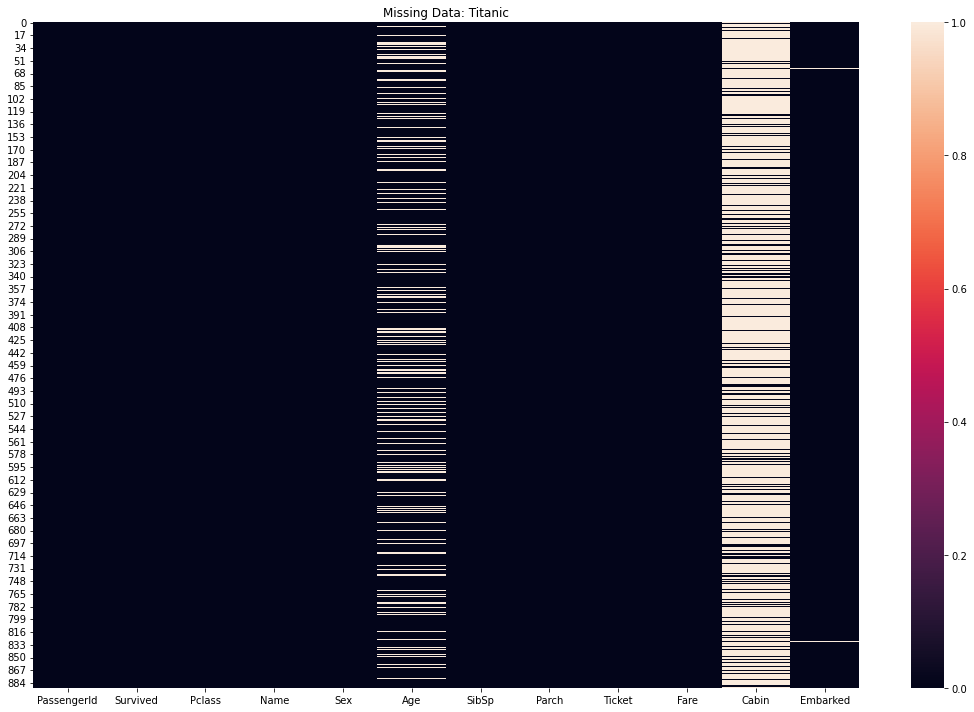

In [5]:
"""document missing data visually"""

# seabornn heatmap of missing values
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(titanic.isnull())
plt.title('Missing Data: Titanic')
plt.tight_layout()

In [6]:
"""document data types for each feature"""

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
"""did more women or men die (numeric exploration)"""

titanic[['Survived', 'Sex']].groupby(by=['Sex'], dropna=True)['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Survival by Sex (0=Perished, 1=Survived)')

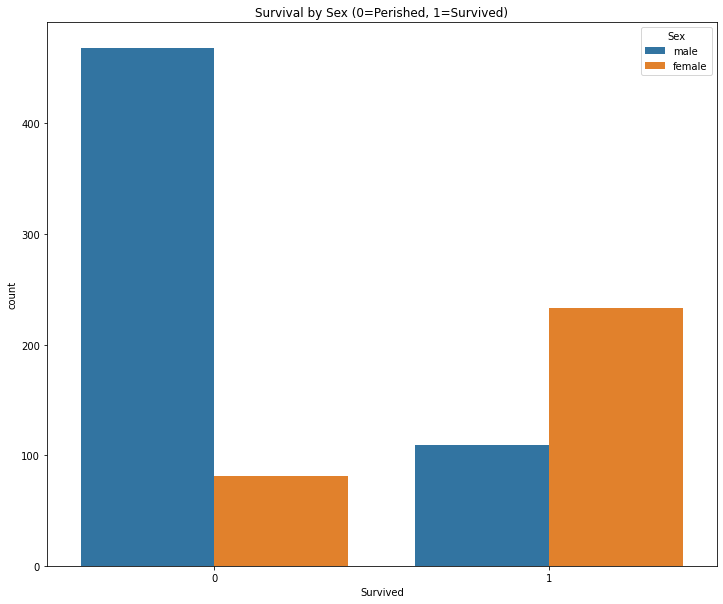

In [8]:
"""did more women or men die visual exploration"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=titanic, x='Survived', hue='Sex')
plt.title('Survival by Sex (0=Perished, 1=Survived)')

In [9]:
"""liklehood of survival by class (numeric exploration)"""

titanic[['Survived', 'Pclass']].groupby(by=['Pclass'],
                                       dropna=True)\
                                       ['Survived'].value_counts(normalize=True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64

Text(0.5, 1.0, 'Survival by Boarding Class (0=Perished, 1=Survived)')

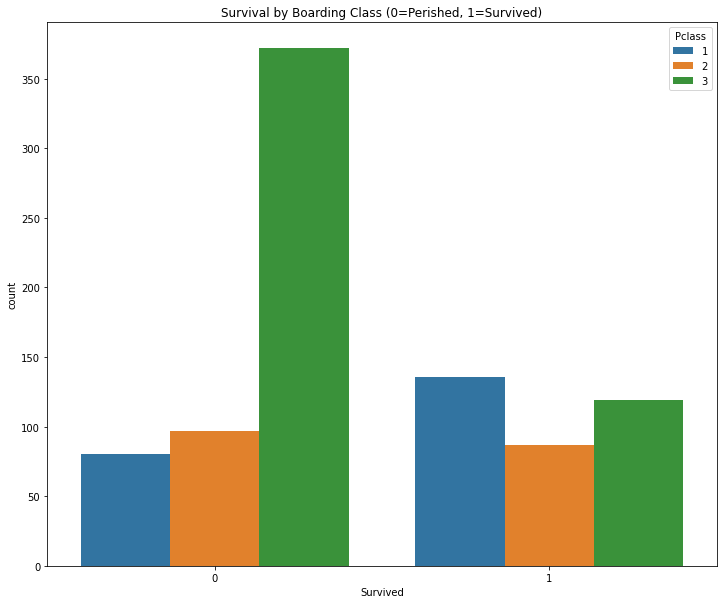

In [10]:
"""likelihood of survival by class visual exploration"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=titanic, x='Survived', hue='Pclass')
plt.title('Survival by Boarding Class (0=Perished, 1=Survived)')

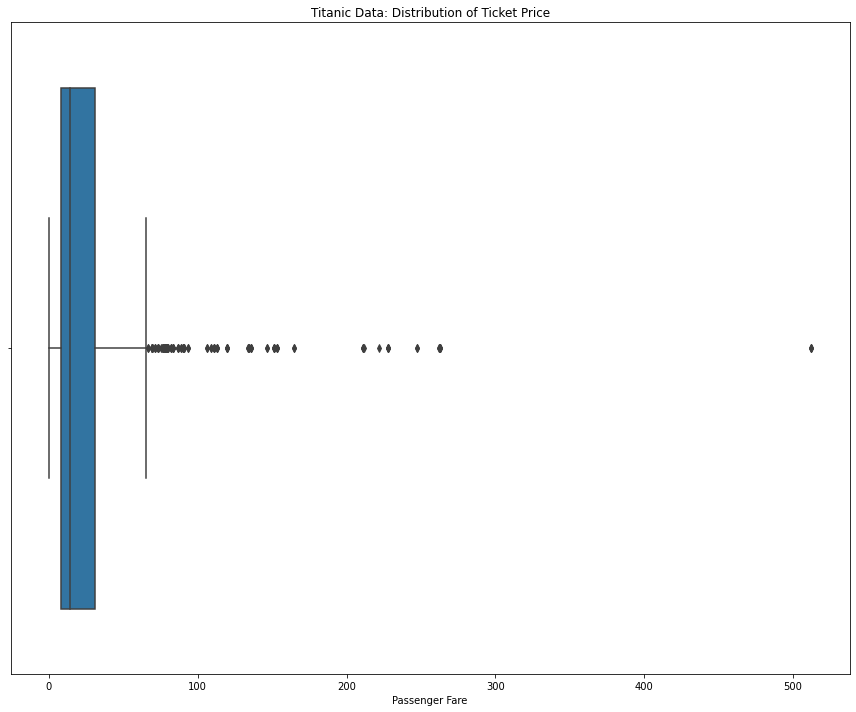

In [11]:
fig, axs = plt.subplots(figsize=(12, 10))
sns.boxplot(data=titanic, x="Fare")
plt.xlabel('Passenger Fare')
plt.title('Titanic Data: Distribution of Ticket Price')
plt.tight_layout()

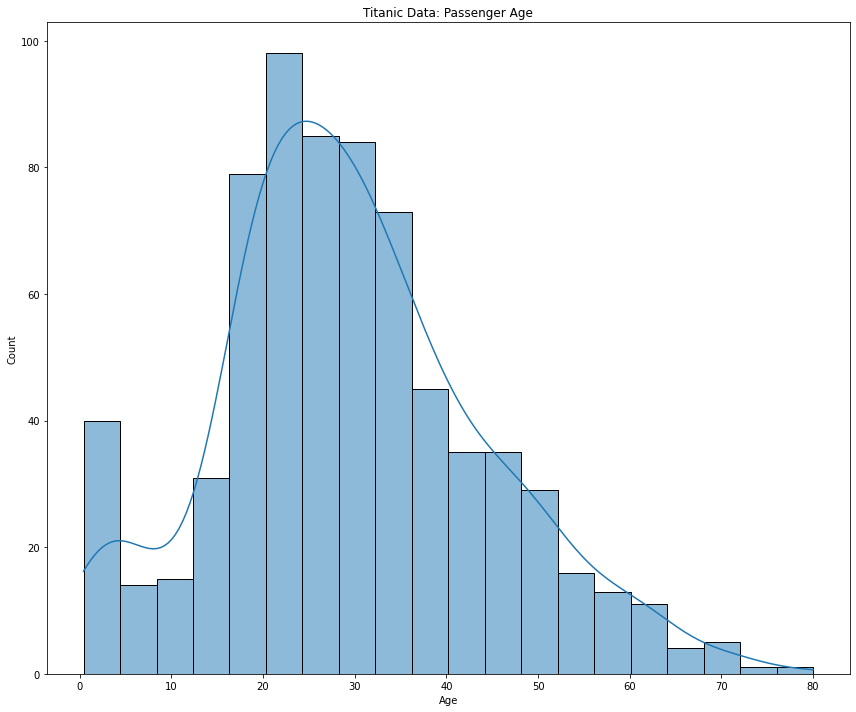

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.histplot(data=titanic, x='Age', kde=True)
plt.title('Titanic Data: Passenger Age')
plt.tight_layout()

In [13]:
"""print the median age of each passenger class"""

median_vals = titanic[['Age', 'Pclass']].groupby(by=['Pclass']).median()
median_vals

,Age
Pclass,
1,37.0
2,29.0
3,24.0


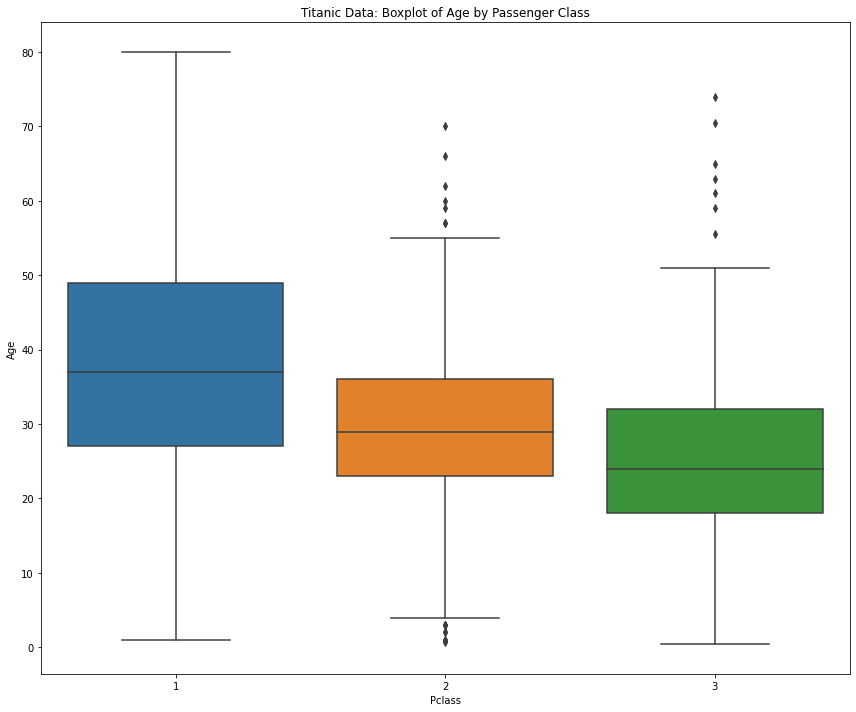

In [14]:
"""boxplot of age by passenger class"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(data=titanic, x='Pclass', y='Age')
plt.title('Titanic Data: Boxplot of Age by Passenger Class')
plt.tight_layout()

## *Part 2: Data Cleansing*

Objectives

- Drop the "cabin" feature from the dataset
- Impute missing values in the age feature using median age value of a passengers respective boarding class
- Drop all remaining records with null values
- Ensure all null values have been removed
- Convert categorical values to dummies using pd.get_dummies() function
- Drop the "name", "ticket", and "passengerid" features
- Copy contents of the "survived" feature vecture to a new dataframe, this is the target label
- split the data into training and test sets

In [15]:
"""drop the cabin feature from the titanic dataframe"""

titanic.drop(columns=['Cabin'], inplace=True)

In [16]:
titanic['Pclass']

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64

In [17]:
"""
Impute missing values in the age feature using median age value of a passengers
respective boarding class. Boolean index used instead of pd.apply, faster and easir syntax
"""

titanic.loc[(titanic['Pclass'] == 1) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][1]
titanic.loc[(titanic['Pclass'] == 2) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][2]
titanic.loc[(titanic['Pclass'] == 3) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][3]
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [18]:
"""drop remaining rows with missing values"""

titanic.dropna(axis=0,  inplace=True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [19]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [20]:
"""
Drop features name, ticket, and passengerid
get dummies for remaining categorical features then drop origina columns
"""

titanic.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)
categorical_idx = titanic.select_dtypes(exclude=['int64', 'float64']).columns
dummy_vars = pd.get_dummies(titanic[categorical_idx])
titanic = pd.concat([titanic, dummy_vars], axis=1)
titanic.drop(columns=categorical_idx, inplace=True)


In [21]:
"""
create the feature set by copying target label to new dataframe and dropping from features
split data into traning and test sets
"""
y = titanic['Survived'].copy()
titanic.drop(columns=['Survived'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(titanic, y,test_size=.30,
                                                    random_state=14)

## *Part 3: Model Tuning*

Objectives

- Implement a logisitc regression model
- Implement a support vector classifier
- implement a sgd classifier
- Print classifcation reports for each model
- Print confusion matrices for each model
- Print ROC score and and chart for each model

In [95]:
"""implement a simple logisitic regression model with cross validation"""

lrm = LogisticRegression(max_iter=500)
lrm.fit(X_train, y_train)
train_predicted = cross_val_predict(lrm, X_train, y_train, cv=3)

In [96]:
"""print classification report for the logiistic regression model"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       384
           1       0.75      0.67      0.71       238

    accuracy                           0.79       622
   macro avg       0.78      0.76      0.77       622
weighted avg       0.78      0.79      0.78       622



In [97]:
"""print confusion matrix for logistic regression model"""

confusion_matrix(y_train, train_predicted)

array([[330,  54],
       [ 79, 159]])

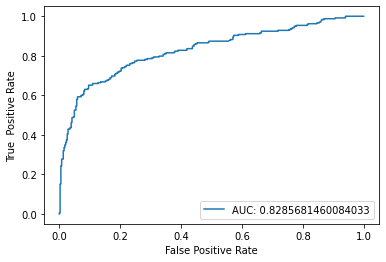

In [123]:
"""print receiver operating characteristic for logistic regression model"""

predicted_probs = cross_val_predict(lrm, X_train, y_train, cv=3, method='predict_proba')
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
#plt.figure(figsize=(12, 10))
plt.show()

In [131]:
"""
implement a simple support vector classifier with rbf kernel
"""

svc = SVC(kernel='rbf', gamma='auto', C=1, probability=True)
svc.fit(X_train, y_train)
#train_predicted = cross_val_predict(svc, X_train, y_train, cv=3, method='decision_function')
train_predicted = cross_val_predict(svc, X_train, y_train, cv=3)

In [128]:
"""print classification report for support vector classifier"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       384
           1       0.64      0.49      0.55       238

    accuracy                           0.70       622
   macro avg       0.68      0.66      0.66       622
weighted avg       0.69      0.70      0.69       622



In [129]:
"""print confusion matrix for support vector classifier"""

confusion_matrix(y_train, train_predicted)

array([[318,  66],
       [122, 116]])

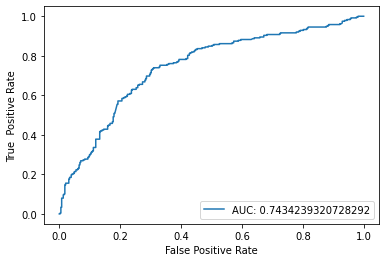

In [134]:
"""print/plot receiver operating characteristic for support vector classifier"""

predicted_probs = cross_val_predict(svc, X_train, y_train, cv=3, method='predict_proba')
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
#plt.figure(figsize=(12, 10))
plt.show()

In [ ]:
"""print receiver operating characteristic for logistic regression model"""

predicted_probs = cross_val_predict(lrm, X_train, y_train, cv=3, method='predict_proba')
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
#plt.figure(figsize=(12, 10))
plt.show()

In [143]:
"""implement a simple stochastic gradient descent model"""

sgd = SGDClassifier(max_iter=1000, early_stopping=True, random_state=14, penalty='elasticnet')
sgd.fit(X_train, y_train)
train_predicted = cross_val_predict(sgd, X_train, y_train, cv=3)

In [144]:
"""print classification report for stochastic gradient descent model"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       384
           1       0.46      0.63      0.54       238

    accuracy                           0.58       622
   macro avg       0.59      0.59      0.58       622
weighted avg       0.61      0.58      0.59       622



In [145]:
"""print confusion matrix for stochastic gradient descent model"""

confusion_matrix(y_train, train_predicted)

array([[210, 174],
       [ 87, 151]])

In [146]:
"""print receiver operating characteristic for logistic regression model"""

predicted_probs = cross_val_predict(sgd, X_train, y_train, cv=3, method='decision_function')
"""
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
#plt.figure(figsize=(12, 10))
plt.show()
"""

"\nprobs_array = predicted_probs[::, 1]\nfpr, tpr, thresholds = roc_curve(y_train, probs_array)\nauc = roc_auc_score(y_train, probs_array)\nplt.plot(fpr, tpr, label='AUC: '+str(auc))\nplt.ylabel('True  Positive Rate')\nplt.xlabel('False Positive Rate')\nplt.legend(loc=4)\n#plt.figure(figsize=(12, 10))\nplt.show()\n"

## *Part 4*

Objectives

- Implement an sklearn pipeline to scale input features and instantiate a support vector classifier
- Perform a grid search with parameters specified in the assignment instructions using the support vector classification model pipeline
- Print the best estimator, its parameters, and the resulting score
- Apply the best estimator to the test set
- Implement a learning curve using the best estimator. Apply graph styling specified in the assignment instructions